#Import Gym Environment - Mountain Car v0

A car is on a one-dimensional track, positioned between two "mountains". The goal is to drive up the mountain on the right; however, the car's engine is not strong enough to scale the mountain in a single pass. Therefore, the only way to succeed is to drive back and forth to build up momentum.

We'll try to solve this using an off-policy MC control algorithm where b is the off policy (epsilon soft of pi) and pi is a greedy policy. 

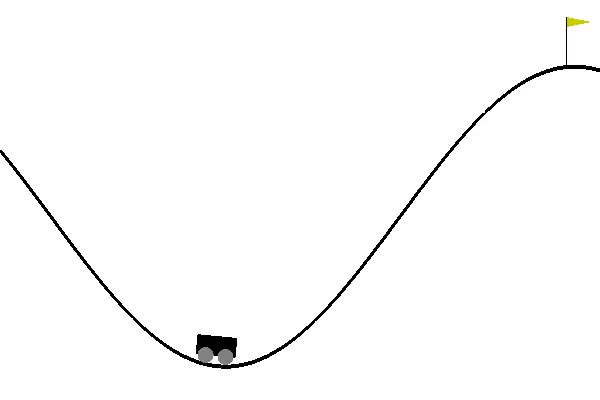




**Obersvations :**

0 : position [-1.2,0.6]

1 : velocity [-0.07,0.07]

**Action:**

0: push left

1: no push

2: push right

**Reward:**

-1 for each time step, until the goal position of 0.5 is reached. As with MountainCarContinuous v0, there is no penalty for climbing the left hill, which upon reaching the end (-1.2) acts as a wall.

**Starting State**

Random position from -0.6 to -0.4 with no velocity.


**Episode Termination**

The episode ends when you reach 0.5 position, or if 200 iterations are reached.




In [ ]:
!apt-get install -y xvfb python-opengl > /dev/null 2>&1
!pip install gym pyvirtualdisplay > /dev/null 2>&1


In [ ]:
import gym
import numpy as np
import matplotlib.pyplot as plt
from IPython import display as ipythondisplay
import pandas as pd

In [ ]:
from pyvirtualdisplay import Display
display = Display(visible=0, size=(400, 300))
display.start()
env = gym.make("MountainCar-v0")
env.reset()

array([-0.54989878,  0.        ])

Discretize the state space and save as a list such that it will be used for all future control algorithms in this assignment.

In [ ]:
#discretize the continous state space # cos = pos
pos_space = np.linspace(-1.2,0.6, 20)
vel_space = np.linspace(-0.07, 0.07, 20)

n_S = len(pos_space)*len(vel_space)
s = np.zeros(shape = (n_S, 2)) #each state has an array of 2 numbers

pos_index = 0 
vel_index = 0

for i in range(n_S):
    s[i][0] = pos_space[pos_index]
    s[i][1] = vel_space[vel_index]

    vel_index += 1
    if vel_index == len(vel_space):
        vel_index = 0
        pos_index+=1
        #if sin_index == len(sin_space):
            #sin_index = 0
            #pos_index+=1
            #if cv_index == len(cv_space):
                #cv_index = 0
                #cp_index +=1
s = s.tolist()



#Exercise 1

## Off-policy Monte Carlo Control
Develop off-policy Monte Carlo control algorithm:




##Off-policy Monte Carlo Control 

In [ ]:
def disc_state(s):
    #give state as a list of ints and return is list of ints
    s_disc = [min(pos_space, key=lambda x:abs(x-s[0])), min(vel_space, key=lambda x:abs(x-s[1]))]
    return s_disc

def off_policy(pi,s,Q,t):

    if np.random.uniform(0,1) < max(0.001, min(0.015, 1.0 - np.log((t+1)/200.))):
        #take any random possible action
        a = env.action_space.sample()
    else:
        #take greedy action following policy pi
        a = np.argmax(Q[str(s)])
    return a

def gen_episode_b(pi,Q):
    #generate episode following policy b
    episode = []
    s = disc_state(list(env.reset()))
    t=0
    while True:
        a = off_policy(pi,s,Q,t)
        s_, r, gameState, _ = env.step(a)
        s_ = disc_state(list(s_))
        episode.append((s, a, r, s_))
        s = s_
        if gameState == True:
            break
        t+=1
    return episode


def MC_OP_Control(Q, C, pi, maxEpisode):
    avg_reward_per_episode = []
    discount = 0.95
    for episode in range(maxEpisode):
        episode = gen_episode_b(pi,Q)
        
        G = 0
        W = 1
        
        T = len(episode)
        for i in range(T):
            t = T - i -1
            G = discount*G + episode[t][2] 
            C[str(episode[t][0])][episode[t][1]] += W
            Q[str(episode[t][0])][episode[t][1]] += (W/C[str(episode[t][0])][episode[t][1]])*(G - Q[str(episode[t][0])][episode[t][1]])
            pi[str(episode[t][0])] = [0,0,0]
            pi[str(episode[t][0])][np.argmax(Q[str(episode[t][0])])] = 1
            
            if episode[t][1] != np.argmax(Q[str(episode[t][0])]):
                rewards = []
                for i in range(5):
                    rewards.append(test_policy(Q))
                avg_reward_per_episode.append(np.mean(rewards))
                break
            W = W*(1 / pi[str(episode[t][0])][episode[t][1]])

    plt.plot(avg_reward_per_episode)
    plt.title('off-policy Monte Carlo average return over training epsiodes')
    plt.ylabel('Average Reward Until Completion')
    plt.xlabel('Training episodes')
    plt.show()
    return Q

def test_policy(Q):   

    s = disc_state(env.reset())
    #prev_screen = env.render(mode='rgb_array')
    #plt.imshow(prev_screen)

    for i in range(200):
        action = np.argmax(Q[str(s)])
        #print("step i",i,"action=",action)
        s_, r, gameState, _ = env.step(action)
        #print("obs=",s_,"reward=",reward,"done=",done,"info=",info)
        #screen = env.render(mode='rgb_array')
  
        #plt.imshow(screen)
        #ipythondisplay.clear_output(wait=False)
        #ipythondisplay.display(plt.gcf())
        s = disc_state(s_)
        if gameState:
            return i+1
            break
    
    #ipythondisplay.clear_output(wait=False)
    env.close()
    #print("Iterations that were run:",i)

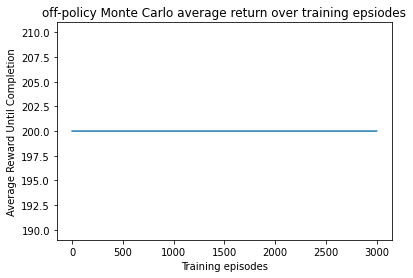

In [ ]:
n_A = 3

Q = {}
C = {}
pi = {}
for state in list(s):
    Q[str(state)] = [0,0,0]
    C[str(state)] = [0,0,0]
    pi[str(state)] = [1,0,0]
    pi[str(state)][np.argmax(Q[str(state)])] = 1

Q_MC_optimal = MC_OP_Control(Q,C,pi, 3000)

In [ ]:
MC_results = []
for i in range(200):
    result = test_policy(Q_MC_optimal)
    MC_results.append(result)
MC_results_avg = np.mean(MC_results)
print('The average episode length until termination from the policy computed from the above off-policy MC algorithm is: ', np.mean(MC_results_avg))

The average episode length until termination from the policy computed from the above off-policy MC algorithm is:  200.0


##Summary of Results

As shown in the results above the MC control algorithm does not perform well for this task. The average iterations until completion of the task was 200 which is also the auto termination point (meaning it doesn't reach position 0.5 and faield the task). Additionally we see no improvement at all during learning through the trianing episodes. 

Despite 3000 training episodes the resulting policy still performs poorly never completing the problem within 200 iterations for each run. This indicates the MC is learning too slowly or not at all  since the gameState ends after 200 episodes it never generates an episode that completes the task. If the max iterations was altered to say 1000 the MC method may show better results however this just confirms what we already know which is MC is a slow learner since it requires computation of the full return of an episode.

#Task 1

TD(0)
1. on-policy SARSA
2. on-policy expected SARSA
3. off-policy expected SARSA with a greedy control policy.

##TD(0) On-policy SARSA Control

In [ ]:
def action_selection(s, t, Q):
    if np.random.random() < max(0.001, min(0.015, 1.0 - np.log((t+1)/220.))):
        return env.action_space.sample()
    
    return np.argmax(Q[str(s)])



def on_pol_SARSA(Q, maxEpisode):
    discount = 0.99
    avg_reward_per_episode = []
    for i in range(maxEpisode):
        t = 0
        s = disc_state(env.reset())
        while True:
            a = action_selection(s,t,Q)
            s_, r, gameState, _ = env.step(a)
            s_ = disc_state(s_)
            a_ = action_selection(s_,t,Q)
            Q[str(s)][a] += max(0.4, min(0.1, 1.0 - np.log((t+1)/125.)))*(r + discount* Q[str(s_)][a_] - Q[str(s)][a])
            s = s_
            a = a_
            t+=1
            if gameState:
                rewards = []
                for i in range(5):
                    rewards.append(test_policy(Q))
                avg_reward_per_episode.append(np.mean(rewards))
                break
    plt.plot(avg_reward_per_episode)
    plt.title('on-policy SARSA average return over training epsiodes')
    plt.ylabel('Average Reward Until Completion')
    plt.xlabel('Training episodes')
    plt.show()
    return Q


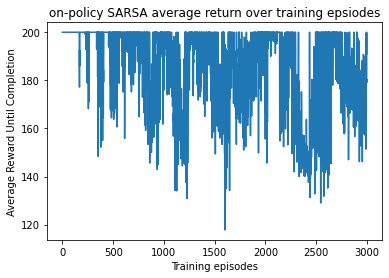

In [ ]:
Q = {}
for state in list(s):
    Q[str(state)] = [0,0,0]

Q_on_pol_SARSA = on_pol_SARSA(Q, 3000)

In [ ]:
Q_SARSA_0_results = []
for i in range(200):
    result = test_policy(Q_on_pol_SARSA)
    Q_SARSA_0_results.append(result)
Q_n_SARSA_0_avg = np.mean(Q_SARSA_0_results)
print('The average episode length until termination for TD(0) using n-SARSA is: ', Q_n_SARSA_0_avg)

The average episode length until termination for TD(0) using n-SARSA is:  174.355


##TD(0) On-policy Expected SARSA Control

In [ ]:
def update_pi(Q,pi,s, t):
    epsilon = max(0.001, min(0.015, 1.0 - np.log((t+1)/220.)))
    pi[str(s)] = [epsilon/3,epsilon/3,epsilon/3 ]
    pi[str(s)][np.argmax(Q[str(s)])] += 1-epsilon 
    return pi

def on_pol_exp_SARSA(Q, maxEpisode, pi):
    discount = 0.99
    avg_reward_per_episode = []
    for i in range(maxEpisode):
        t = 0
        s = disc_state(env.reset())
        while True:
            a = action_selection(s,t,Q)
            s_, r, gameState, _ = env.step(a)
            s_ = disc_state(s_)
            Q[str(s)][a] += max(0.4, min(0.1, 1.0 - np.log((t+1)/125.)))*(r + discount* (pi[str(s_)][0]*Q[str(s_)][0]+pi[str(s_)][1]*Q[str(s_)][1]+pi[str(s_)][2]*Q[str(s_)][2]) - Q[str(s)][a])
            pi = update_pi(Q,pi,s,t)
            s = s_
            t+=1
            if gameState:
                rewards = []
                for i in range(5):
                    rewards.append(test_policy(Q))
                avg_reward_per_episode.append(np.mean(rewards))
                break
    plt.plot(avg_reward_per_episode)
    plt.title('off-policy expected SARSA average return over training epsiodes')
    plt.ylabel('Average Reward Until Completion')
    plt.xlabel('Training episodes')
    plt.show()
    return Q


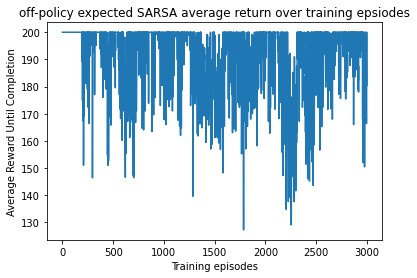

In [ ]:
Q = {}
pi = {}
for state in list(s):
    Q[str(state)] = [0,0,0]
    pi[str(state)] = [0,0,0]
    pi[str(state)][np.argmax(Q[str(state)])] = 1


Q_off_pol_exp_SARSA = on_pol_exp_SARSA(Q,3000, pi)

In [ ]:
Q_exp_SARSA_0_results = []
for i in range(200):
    result = test_policy(Q_off_pol_exp_SARSA)
    Q_exp_SARSA_0_results.append(result)
Q_exp_SARSA_0_avg = np.mean(Q_exp_SARSA_0_results)
print('The average episode length until termination for TD(0) using expected n-SARSA is: ', Q_exp_SARSA_0_avg)

The average episode length until termination for TD(0) using expected n-SARSA is:  173.995


##TD(0) Off-policy expected SARSA Control (greedy)

In [ ]:
def off_policy_action_selection(s, t, Q):
    if np.random.random() < 0.05:

        return env.action_space.sample()
    
    return np.argmax(Q[str(s)])


def off_pol_exp_SARSA(Q, maxEpisode, pi):
    discount = 0.99
    avg_reward_per_episode = []
    for i in range(maxEpisode):
        t = 0
        s = disc_state(env.reset())
        while True:
            a = off_policy_action_selection(s,t,Q)
            s_, r, gameState, _ = env.step(a)
            s_ = disc_state(s_)
            Q[str(s)][a] += max(0.4, min(0.1, 1.0 - np.log((t+1)/350.)))*(r + discount* (pi[str(s_)][0]*Q[str(s_)][0]+pi[str(s_)][1]*Q[str(s_)][1]+pi[str(s_)][2]*Q[str(s_)][2]) - Q[str(s)][a])
            pi = update_pi(Q,pi,s,t)
            s = s_
            t+=1
            if gameState:
                rewards = []
                for i in range(5):
                    rewards.append(test_policy(Q))
                avg_reward_per_episode.append(np.mean(rewards))
                break
    plt.plot(avg_reward_per_episode)
    plt.title('off-policy expected SARSA average return over training epsiodes')
    plt.ylabel('Average Reward Until Completion')
    plt.xlabel('Training episodes')
    plt.show()
    return Q

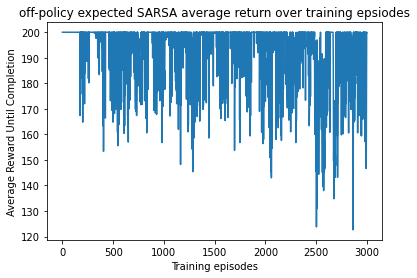

In [ ]:
Q = {}
pi = {}
for state in list(s):
    Q[str(state)] = [0,0,0]
    pi[str(state)] = [0,0,0]
    pi[str(state)][np.argmax(Q[str(state)])] = 1


Q_off_pol_exp_SARSA_greedy = off_pol_exp_SARSA(Q,3000, pi)

In [ ]:
Q_off_pol_SARSA_0_results = []
for i in range(200):
    result = test_policy(Q_off_pol_exp_SARSA_greedy)
    Q_off_pol_SARSA_0_results.append(result)
Q_off_pol_SARSA_0_avg = np.mean(Q_off_pol_SARSA_0_results)
print('The average episode length until termination for TD(0) using off-policy expected n-SARSA is: ', Q_off_pol_SARSA_0_avg)

The average episode length until termination for TD(0) using off-policy expected n-SARSA is:  189.785


##Summary of Results

discount = 0.95

LR = max(0.4, min(0.1, 1.0 - log((t+1)/350.)))

training episodes = 3000

In [ ]:
pd.DataFrame(data = [Q_n_SARSA_0_avg,Q_exp_SARSA_0_avg,Q_off_pol_SARSA_0_avg], index = ['On-policy SARSA','On-policy Expected SARSA','Off-policy expected SARSA (greedy)'], columns = ['Average episode length (200 episodes)'])

,Average episode length (200 episodes)
On-policy SARSA,174.355
On-policy Expected SARSA,173.995
Off-policy expected SARSA (greedy),189.785


As show in the table of results above the TD(0) on-policy expected SARSA had the best performance with the lowest average return per episode (completed the task the fastest). TD(0) on-policy SARSA performed similarily although slightly worse and off-policy expected SARSA with greedy control policy performed the worst although they are relatively close compared to the variance.

The graphs shown above display the variance of the policy performance for the algorithms during training. Expected SARSA appears to be the most stable as the training episodes increase. Expected SARSA also follows the general trend of SARSA as expected but with less variance. I think expected SARSA in general is the better selection since with SARSA there is more fluctuation in performance during training.   

The off-policy expected SARSA used an epsilon value of 0.05 which is greater than those used for on-policy SARSA and expected SARSA. It appeared to have learned faster initially than the others which had a epsilon value of max(0.001, min(0.015, 1.0 - log((t+1)/220.))) which decays over time but the overall performance was worse. I likely need to decrease the epsilon such that we can progress through episodes fast enough before hitting the 200 step limit in order to learn values of all states. An epsilon of 0.05 likely results in poorer learning because the cart never makes it up the hill very far in 200 episodes and doesn't explore those states / state-action pairs. 

#Exercise 2



##n-Step TD Prediction

In [ ]:
def update_pi_V(V,pi,s, t):
    epsilon = max(0.001, min(0.015, 1.0 - np.log((t+1)/220.)))
    pi[str(s)] = [epsilon/3,epsilon/3,epsilon/3 ]
    pi[str(s)][np.argmax(V[str(s)])] += 1-epsilon 
    return pi

def n_TD(n,Q,maxEpisode,pi):
    discount = 0.95
    for i in range(maxEpisode):
        R = [0]
        S = []
        A = []
        s = disc_state(env.reset())
        S.append(s)
        T = 10000
        for t in range(T):
            if t<T:
                a = action_selection(str(S[t]),t,V)
                A.append(a)
                s_, r, gameState, _ = env.step(A[t])
                s_ = disc_state(s_)
                S.append(s_)
                R.append(r)
                if gameState == True:
                    T = t+1
            tau = t-n+1
            if tau >= 0:
                G = 0
                for i in range(tau+1,min(tau+n,T)+1):
                    G += (discount**(i-tau-1))*R[i]
                if tau + n < T:
                    G += (discount**n)*V[str(S[tau+n])][0]
                
                V[str(S[tau])][0] += max(0.4, min(0.1, 1.0 - np.log((t+1)/125.)))*(G - V[str(S[tau])][0])
                pi = update_pi_V(V, pi, S[tau], t)
            if tau == T-1:
                break
            s = s_

    return V


In [ ]:
V = {}
pi = {}
for state in list(s):
    V[str(state)] = [0]
    pi[str(state)] = [0,0,0]
    pi[str(state)][np.argmax(V[str(state)])] = 1


V_n_TD = n_TD(4,V,1000,pi)

In [ ]:
V_n_TD

{'[-0.06315789473684208, -0.00368421052631579]': [0],
 '[-0.06315789473684208, -0.01105263157894737]': [0],
 '[-0.06315789473684208, -0.01842105263157895]': [0],
 '[-0.06315789473684208, -0.02578947368421053]': [0],
 '[-0.06315789473684208, -0.03315789473684211]': [0],
 '[-0.06315789473684208, -0.04052631578947369]': [0],
 '[-0.06315789473684208, -0.04789473684210527]': [0],
 '[-0.06315789473684208, -0.05526315789473685]': [0],
 '[-0.06315789473684208, -0.06263157894736843]': [0],
 '[-0.06315789473684208, -0.07]': [0],
 '[-0.06315789473684208, 0.00368421052631579]': [0],
 '[-0.06315789473684208, 0.01105263157894737]': [0],
 '[-0.06315789473684208, 0.01842105263157895]': [0],
 '[-0.06315789473684208, 0.02578947368421053]': [0],
 '[-0.06315789473684208, 0.03315789473684211]': [0],
 '[-0.06315789473684208, 0.04052631578947369]': [0],
 '[-0.06315789473684208, 0.04789473684210527]': [0],
 '[-0.06315789473684208, 0.05526315789473685]': [0],
 '[-0.06315789473684208, 0.06263157894736843]': [0]

## n-Step SARSA (on-policy) Control

In [ ]:
def update_pi(Q,pi,s, t):
    epsilon = max(0.001, min(0.015, 1.0 - np.log((t+1)/220.)))
    pi[str(s)] = [epsilon/3,epsilon/3,epsilon/3 ]
    pi[str(s)][np.argmax(Q[str(s)])] += 1-epsilon 
    return pi

def n_SARSA(n, Q, maxEpisode, pi):
    avg_returns = []
    discount = 0.95
    for i in range(maxEpisode):
        R = [0]
        S = []
        A = []
        t = 0
        s = disc_state(env.reset())
        a = action_selection(s,t,Q)
        S.append(s)
        A.append(a)
        T = 10000
        for t in range(T):
            if t < T:
                s_, r, gameState, _ = env.step(A[t])
                R.append(r)
                S.append(disc_state(s_))
                if gameState == True:
                    T = t+1
                else:
                    a_ = action_selection(disc_state(S[t+1]),t+1,Q)
                    A.append(a_)
            tau = t - n + 1 
            if tau >= 0:
                G = 0
                for i in range(tau+1,min(tau+n,T)+1):
                    G += (discount**(i-tau-1))*R[i]
                if tau + n < T:

                    G += (discount**n)*Q[str(S[tau+n])][A[tau+n]]
                Q[str(S[tau])][A[tau]] += max(0.4, min(0.1, 1.0 - np.log((t+1)/350.)))*(G - Q[str(S[tau])][A[tau]])
                update_pi(Q, pi, S[tau], t)
            if tau == T - 1:
                break
            s = s_
            a = a_

        returns = []
        for i in range(5):
            returns.append(test_policy(Q))
        avg_returns.append(np.mean(returns))
    plt.plot(avg_returns)
    plt.title('n-step SARSA average return over training epsiodes')
    plt.ylabel('Average Reward Until Completion')
    plt.xlabel('Training episodes')
    plt.show()
    
    return Q



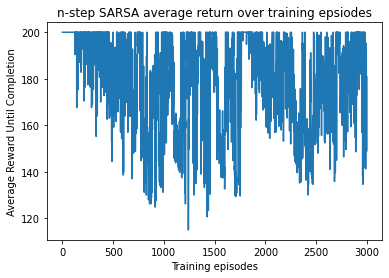

In [ ]:
Q = {}
pi = {}
for state in list(s):
    Q[str(state)] = [0,0,0]
    pi[str(state)] = [0,0,0]
    pi[str(state)][np.argmax(Q[str(state)])] = 1


Q_n_SARSA_4 = n_SARSA(4,Q,3000,pi)

## Off-policy Tree Backup Control

In [ ]:
def update_greedy_pi(Q,pi,s, t):
    pi[str(s)] = [0,0,0]
    pi[str(s)][np.argmax(Q[str(s)])] += 1
    return pi


def off_pol_tree(n, Q, maxEpisode, pi):
    avg_returns = []
    discount = 0.95
    for i in range(maxEpisode):
        S = []
        A = []
        R = [0]
        s = disc_state(env.reset())
        #a = env.action_space.sample()
        t=0
        a = action_selection(s,t,Q)
        S.append(s)
        A.append(a)
        T = 10000   
        for t in range(T):
            if t < T:
                s_, r, gameState, _ = env.step(A[t])
                S.append(disc_state(s_))
                R.append(r)
                if gameState == True:
                    T = t + 1
                else:
                    A.append(action_selection(str(S[t+1]),t,Q))
            tau = t + 1 - n
            if tau >= 0:
                G=0
                if t+1 >= T:
                    G = R[T]
                else:
                    G = R[t+1]+discount*(r + discount*(pi[str(S[t+1])][0]*Q[str(S[t+1])][0]+pi[str(S[t+1])][1]*Q[str(S[t+1])][1]+pi[str(S[t+1])][2]*Q[str(S[t+1])][2]))
                for k in range(min(t,T-1),tau+1,-1):
                    G += R[k]
                    if A[k] == 0:
                        G += discount*(pi[str(S[k])][1]*Q[str(S[k])][1] + pi[str(S[k])][2]*Q[str(S[k])][2]) + discount*pi[str(S[k])][0]*G
                    elif A[k] == 1:
                        G += discount*(pi[str(S[k])][0]*Q[str(S[k])][0] + pi[str(S[k])][2]*Q[str(S[k])][2]) + discount*pi[str(S[k])][1]*G
                    elif A[k] == 2:
                        G += discount*(pi[str(S[k])][0]*Q[str(S[k])][0] + pi[str(S[k])][1]*Q[str(S[k])][1]) + discount*pi[str(S[k])][2]*G  
                Q[str(S[tau])][A[tau]] += max(0.4, min(0.1, 1.0 - np.log((t+1)/350.)))*(G - Q[str(S[tau])][A[tau]])

                pi = update_greedy_pi(Q, pi, str(S[tau]),t)
            if tau == T - 1:
                break
            s = s_
        returns = []
        for i in range(5):
            returns.append(test_policy(Q))
        avg_returns.append(np.mean(returns))
    plt.plot(avg_returns)
    plt.title('off-policy Tree Backup average return over training epsiodes')
    plt.ylabel('Average Reward Until Completion')
    plt.xlabel('Training episodes')
    plt.show()
    return Q

                

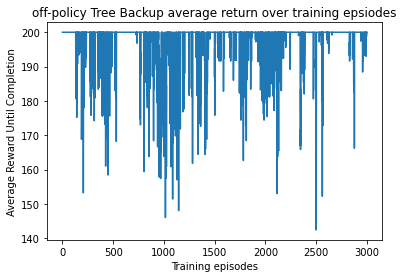

In [ ]:
Q = {}
pi = {}
for state in list(s):
    Q[str(state)] = [0,0,0]
    pi[str(state)] = [0,0,0]
    pi[str(state)][np.argmax(Q[str(state)])] = 1


Q_tree_2 = off_pol_tree(2,Q,3000,pi)

# Task 2
Compute and compare TD(0,2,3,4) using n-SARSA. We can use our work from exercise two which is a general algorithm for TD(n) using n-SARSA where n = {0,2,3,4}

## TD(0) On-policy n-SARSA Control 

This was calculated already in Task 1 so we will use the results for analysis and comparison with the algorithms below. 

In [ ]:
Q_n_SARSA_0_results = []
for i in range(200):
    result = test_policy(Q_on_pol_SARSA)
    Q_n_SARSA_0_results.append(result)
Q_n_SARSA_0_avg = np.mean(Q_n_SARSA_0_results)
print('The average episode length until termination for TD(0) using n-SARSA is: ', Q_n_SARSA_0_avg)

The average episode length until termination for TD(0) using n-SARSA is:  175.86


## TD(2) On-policy n-SARSA Control 

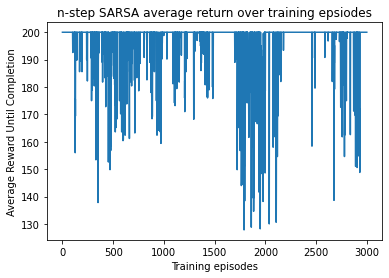

In [ ]:
Q = {}
pi = {}
for state in list(s):
    Q[str(state)] = [0,0,0]
    pi[str(state)] = [0,0,0]
    pi[str(state)][np.argmax(Q[str(state)])] = 1


Q_n_SARSA_2 = n_SARSA(2,Q,3000,pi)

In [ ]:
Q_n_SARSA_2_results = []
for i in range(200):
    result = test_policy(Q_n_SARSA_2)
    Q_n_SARSA_2_results.append(result)
Q_n_SARSA_2_avg = np.mean(Q_n_SARSA_2_results)
print('The average episode length until termination for TD(2) using n-SARSA is: ', Q_n_SARSA_2_avg)


The average episode length until termination for TD(2) using n-SARSA is:  200.0


## TD(3) On-policy n-SARSA Control 

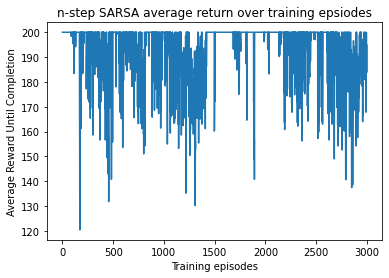

In [ ]:
Q = {}
pi = {}
for state in list(s):
    Q[str(state)] = [0,0,0]
    pi[str(state)] = [0,0,0]
    pi[str(state)][np.argmax(Q[str(state)])] = 1


Q_n_SARSA_3 = n_SARSA(3,Q,3000,pi)

In [ ]:
Q_n_SARSA_3_results = []
for i in range(200):
    result = test_policy(Q_n_SARSA_3)
    Q_n_SARSA_3_results.append(result)
Q_n_SARSA_3_avg = np.mean(Q_n_SARSA_3_results)
print('The average episode length until termination for TD(3) using n-SARSA is: ', Q_n_SARSA_3_avg)


The average episode length until termination for TD(3) using n-SARSA is:  191.39


## TD(4) On-policy n-SARSA Control 

n=4 was run previously in Task 1 so we will use that policy to evaluate its performance.

In [ ]:
Q_n_SARSA_4_results = []
for i in range(200):
    result = test_policy(Q_n_SARSA_4)
    Q_n_SARSA_4_results.append(result)
Q_n_SARSA_4_avg = np.mean(Q_n_SARSA_4_results)
print('The average episode length until termination for TD(3) using n-SARSA is: ', Q_n_SARSA_4_avg)

The average episode length until termination for TD(3) using n-SARSA is:  162.36


##Summary of Results

discount = 0.95

LR = max(0.4, min(0.1, 1.0 - log((t+1)/350.)))

training episodes = 3000

In [ ]:
pd.DataFrame(data = [Q_n_SARSA_0_avg,Q_n_SARSA_2_avg,Q_n_SARSA_3_avg,Q_n_SARSA_4_avg], index = ['TD(0) On-policy SARSA','TD(2) On-policy SARSA','TD(3) On-policy SARSA','TD(4) On-policy SARSA'], columns = ['Average episode length (200 episodes)'])

,Average episode length (200 episodes)
TD(0) On-policy SARSA,175.86
TD(2) On-policy SARSA,200.00
TD(3) On-policy SARSA,191.39
TD(4) On-policy SARSA,162.36


As shown in the table above TD(4) for on-policy SARSA had the best results. However it is noted that TD(2) and TD(3) had worse results than TD(0) which is odd but can likely be explained due to the inherent variance of n-SARSA algorithms compared to expected n-SARSA. As seen in the figures above the algorithm had many training episodes which performed poorly (return 200) over a 5 episode average. Given computational limitations only 5 episodes were used to test a policy at each training episode however a larger number say 100 should be used to get a more accurate estimate of the performance of the policy. If this was done I believe we would see TD(2) perform better than TD(0) and TD(3) perform better than TD(2) but less than TD(4).

Additionally the learning rate could greatly affect the performance and make certain n values better than others, in this analysis we represented the learning rate as a function of time such that it would start small but increase as t increased.

#Bonus Task 3

##TD(2) Off-policy Tree Backup Control

TD(2) for off-policy tree backup was run in Exercise 2 so we will use that policy and evaluate its performance. 

In [ ]:
Q_tree_2_results = []
for i in range(200):
    result = test_policy(Q_tree_2)
    Q_tree_2_results.append(result)
Q_tree_2_avg = np.mean(Q_tree_2_results)
print('The average episode length until termination for TD(2) using Tree Backup is: ', Q_tree_2_avg)

The average episode length until termination for TD(2) using Tree Backup is:  196.605


##TD(3) Off-policy Tree Backup Control

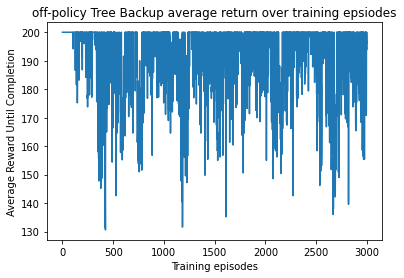

In [ ]:
Q = {}
pi = {}
for state in list(s):
    Q[str(state)] = [0,0,0]
    pi[str(state)] = [0,0,0]
    pi[str(state)][np.argmax(Q[str(state)])] = 1


Q_tree_3 = off_pol_tree(3,Q,3000,pi)

In [ ]:
Q_tree_3_results = []
for i in range(200):
    result = test_policy(Q_tree_3)
    Q_tree_3_results.append(result)
Q_tree_3_avg = np.mean(Q_tree_3_results)
print('The average episode length until termination for TD(3) using Tree Backup is: ', Q_tree_3_avg)

The average episode length until termination for TD(3) using Tree Backup is:  184.815


##TD(4) Off-policy Tree Backup Control

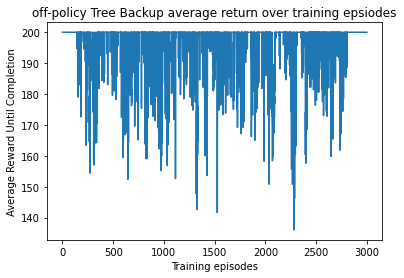

In [ ]:
Q = {}
pi = {}
for state in list(s):
    Q[str(state)] = [0,0,0]
    pi[str(state)] = [0,0,0]
    pi[str(state)][np.argmax(Q[str(state)])] = 1


Q_tree_4 = off_pol_tree(4,Q,3000,pi)

In [ ]:
Q_tree_4_results = []
for i in range(200):
    result = test_policy(Q_tree_4)
    Q_tree_4_results.append(result)
Q_tree_4_avg = np.mean(Q_tree_4_results)
print('The average episode length until termination for TD(4) using Tree Backup is: ', Q_tree_4_avg)

The average episode length until termination for TD(4) using Tree Backup is:  200.0


##Summary of Results

discount = 0.95

LR = max(0.4, min(0.1, 1.0 - log((t+1)/350.)))

training episodes = 3000

In [ ]:
pd.DataFrame(data = [Q_tree_2_avg,Q_tree_3_avg,Q_tree_4_avg], index = ['TD(2) Off-policy Tree Backup','TD(3) Off-policy Tree Backup','TD(4) Off-policy Tree Backup'], columns = ['Average episode length (200 episodes)'])

,Average episode length (200 episodes)
TD(2) Off-policy Tree Backup,196.605
TD(3) Off-policy Tree Backup,184.815
TD(4) Off-policy Tree Backup,200.000


In [ ]:
pd.DataFrame(data = [Q_n_SARSA_0_avg,Q_n_SARSA_2_avg,Q_n_SARSA_3_avg,Q_n_SARSA_4_avg], index = ['TD(0) On-policy SARSA','TD(2) On-policy SARSA','TD(3) On-policy SARSA','TD(4) On-policy SARSA'], columns = ['Average episode length (200 episodes)'])

,Average episode length (200 episodes)
TD(0) On-policy SARSA,175.86
TD(2) On-policy SARSA,200.00
TD(3) On-policy SARSA,191.39
TD(4) On-policy SARSA,162.36


The results of Tree backup for TD(2), TD(3), TD(4) are shown in the table above. The TD(3) performed the best with the lowests average episode length (completion time) of the task. TD(2) did also converge although its performance was poorer and nearly 200. TD(4) did not converge and had an average episode length of 200. We noticed there was significantly more variance in the results for TD(2) and even more for TD(4). 

Our TD(4) n-SARSA model performed the best out of all given each model was using the same discount and learning and rate. Therefore it is the optimal model given the models we have tested and our model hyperparameters. 